In [1]:
# !pip install --upgrade pandas   
# !pip install --upgrade yfinance
# !pip install --upgrade matplotlib
# !pip install -q mplcyberpunk

In [2]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt 
import mplcyberpunk
plt.style.use("cyberpunk")
from datetime import datetime, timedelta

# Calculo para Ações do Ibov VS CDI

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

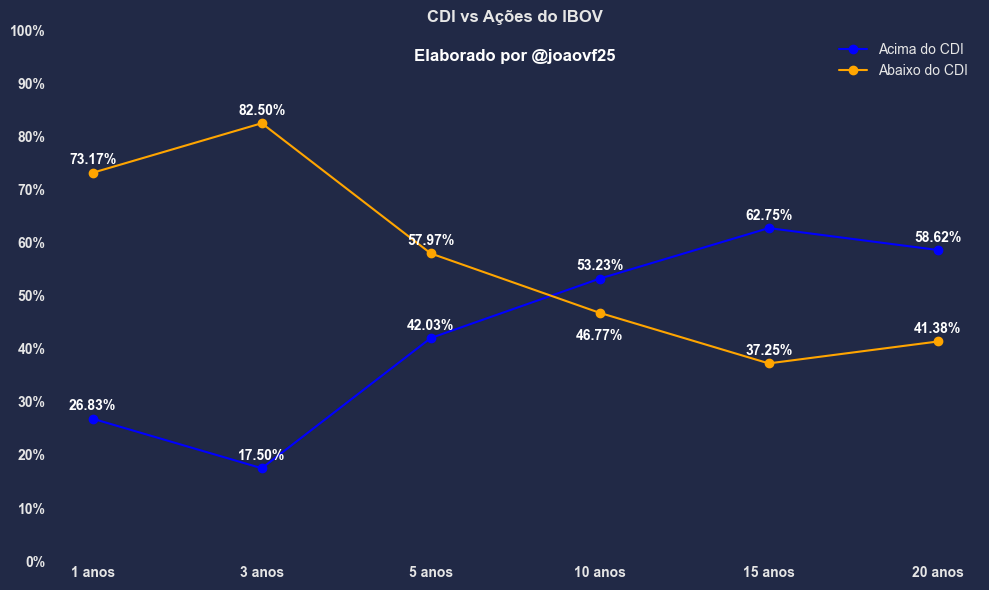

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
import time

# Lista de tickers para pegar de datas específicas porque estava dando erro para puxar no Yfinance pelo desdobramento
tickers_datas_inicio = {
    'LREN3.SA': '2005-07-01',
    'TRPL4.SA': '2006-05-09',
    'UGPA3.SA': '2007-05-07',
    'CMIG4.SA': '2006-05-09'
}

# Lista dos tickers do IBOVESPA
tickers = [
    'RRRP3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ABEV3.SA', 'ARZZ3.SA', 'ASAI3.SA', 'AZUL4.SA', 
    'B3SA3.SA', 'BBSE3.SA', 'BBDC3.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 
    'BRFS3.SA', 'BPAC11.SA', 'CRFB3.SA', 'CCRO3.SA', 'CMIG4.SA', 'CIEL3.SA', 'COGN3.SA', 
    'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CMIN3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 
    'ELET3.SA', 'EMBR3.SA', 'ENGI11.SA', 'ENEV3.SA', 'EGIE3.SA', 'EQTL3.SA', 
    'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'NTCO3.SA', 'SOMA3.SA', 'HAPV3.SA', 
    'HYPE3.SA', 'IGTI11.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 
    'RENT3.SA', 'LREN3.SA', 'LWSA3.SA', 'MGLU3.SA', 'MRFG3.SA', 'BEEF3.SA', 'MRVE3.SA', 
    'MULT3.SA', 'PCAR3.SA', 'PETR4.SA', 'RECV3.SA', 'PRIO3.SA', 'PETZ3.SA', 
    'RADL3.SA', 'RAIZ4.SA', 'RDOR3.SA', 'RAIL3.SA', 'SBSP3.SA', 'SANB11.SA', 'SMTO3.SA', 
    'CSNA3.SA', 'SLCE3.SA', 'SUZB3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TIMS3.SA', 'TOTS3.SA', 
    'TRPL4.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VAMO3.SA', 'VBBR3.SA', 'VIVA3.SA', 
    'WEGE3.SA', 'YDUQ3.SA'
]

# Função para consultar dados do Banco Central com tentativas repetidas 
def consulta_bc(codigo_bcb, data_inicio, data_fim):
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json&dataInicial={data_inicio.strftime("%d/%m/%Y")}&dataFinal={data_fim.strftime("%d/%m/%Y")}'
    while True:
        try:
            df_bcb = pd.read_json(url)
            df_bcb['data'] = pd.to_datetime(df_bcb['data'], dayfirst=True)
            df_bcb.set_index('data', inplace=True)
            return df_bcb
        except Exception as e:
            print(f"Erro ao consultar API do Banco Central: {e}")
            print("Tentando novamente em 1 segundo...")
            time.sleep(1)

def calcular_retorno(data):
    retorno_pct = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    return retorno_pct

# Calculando retorno acumulado do CDI
def calcular_cdi_rendimento(cdi):
    cdi['valor'] = cdi['valor'] / 100
    cdi['acumulado'] = (1 + cdi['valor']).cumprod() - 1
    cdi_rendimento = cdi['acumulado'].iloc[-1] * 100
    return cdi_rendimento

# Função para obter dados de um ticker com data de início específica (LREN3, TRPL4, UGPA3 e CMIG4)
def obter_dados_ticker(ticker, data_inicio, data_fim):
    data = yf.download(ticker, start=data_inicio, end=data_fim)['Adj Close']
    data = data[(data != 0)]  # Remover linhas com valores 0
    return data

# Colocando as janelas das análises
periodos_anos = [1, 3, 5, 10, 15, 20]
resultados_acima = {}
resultados_abaixo = {}

for anos in periodos_anos:
    data_fim = datetime.today()
    data_inicio_padrao = data_fim - timedelta(days=365 * anos)
    
    
    dados_acoes = pd.DataFrame()
    
    # Puxar dados de cada ticker individualmente
    for ticker in tickers_datas_inicio:
        data_inicio = datetime.strptime(tickers_datas_inicio[ticker], '%Y-%m-%d')
        if data_inicio < data_inicio_padrao:
            data_inicio = data_inicio_padrao
        dados_ticker = obter_dados_ticker(ticker, data_inicio, data_fim)
        dados_acoes[ticker] = dados_ticker
    
    # Puxar dados de outros tickers
    for ticker in tickers:
        if ticker not in tickers_datas_inicio:
            dados_ticker = obter_dados_ticker(ticker, data_inicio_padrao, data_fim)
            dados_acoes[ticker] = dados_ticker

    # Verificar se há valores anômalos no início ou no fim dos dados
    dados_acoes = dados_acoes[(dados_acoes != 0).all(1)]  
    
    # Remover ativos que não possuem dados para todo o período
    dados_acoes = dados_acoes.dropna(axis=1, how='any')

    # Calcular o retorno percentual das ações
    retorno_pct = calcular_retorno(dados_acoes)
    df_retorno_pct = pd.DataFrame(retorno_pct, columns=['Retorno Percentual'])
    

    cdi = consulta_bc(12, data_inicio_padrao, data_fim)
    cdi_rendimento = calcular_cdi_rendimento(cdi)
    
    # Comparar os retornos das ações com o CDI
    acoes_acima_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] > cdi_rendimento]
    acoes_abaixo_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] <= cdi_rendimento]
    
    # Calcular a porcentagem de ações acima e abaixo do CDI
    porcentagem_acoes_acima_cdi = (len(acoes_acima_cdi) / len(df_retorno_pct)) * 100
    porcentagem_acoes_abaixo_cdi = (len(acoes_abaixo_cdi) / len(df_retorno_pct)) * 100
    
    resultados_acima[anos] = porcentagem_acoes_acima_cdi
    resultados_abaixo[anos] = porcentagem_acoes_abaixo_cdi

# Plotar os resultados e começar a criar os gráficos
anos = list(resultados_acima.keys())
valores_acima = list(resultados_acima.values())
valores_abaixo = list(resultados_abaixo.values())

fig, ax1 = plt.subplots(figsize=(10, 6))

# Ajustar os índices para espaçamento uniforme e mais organizado
indices = range(len(anos))

ax1.plot(indices, valores_acima, marker='o', linestyle='-', color='b', label='Acima do CDI')
ax1.plot(indices, valores_abaixo, marker='o', linestyle='-', color='orange', label='Abaixo do CDI')
ax1.set_title('CDI vs Ações do IBOV', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()

# Ajustar os limites do eixo x e definir os ticks para garantir espaçamento uniforme e mais organizado
ax1.set_xticks(indices)
ax1.set_xticklabels([f'{ano} anos' for ano in anos], fontweight='bold')

# Adicionar mais divisões no eixo Y e formatar como porcentagem
ax1.set_yticks(range(0, 101, 10))
ax1.yaxis.set_major_formatter(PercentFormatter())
plt.setp(ax1.get_yticklabels(), fontweight='bold')

for i, v in enumerate(valores_acima):
    ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar porcentagens abaixo dos pontos
for i, v in enumerate(valores_abaixo):
    if anos[i] == 10:
        ax1.text(i, v - 3, f"{v:.2f}%", ha='center', va='top', color='white', fontweight='bold')
    else:
        ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar texto meus créditos
plt.text(0.5, 0.95, "Elaborado por @joaovf25", fontsize=12, color='white', fontweight='bold', ha='center', va='center', transform=ax1.transAxes)

plt.grid(False)
plt.tight_layout()
plt.show()


# Calculo para Ações do Ibov VS CDI + 1% a.a

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

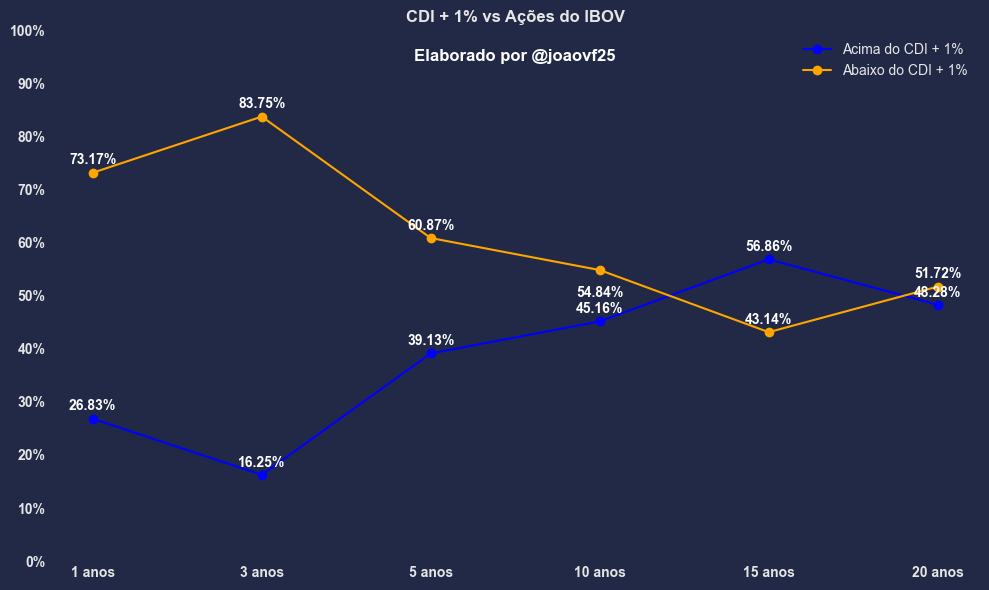

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
import time

# Lista de tickers e suas datas de início específicas
tickers_datas_inicio = {
    'LREN3.SA': '2005-07-01',
    'TRPL4.SA': '2006-05-09',
    'UGPA3.SA': '2007-05-07',
    'CMIG4.SA': '2006-05-09'
}

# Lista de outros tickers sem datas de início específicas
tickers = [
    'RRRP3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ABEV3.SA', 'ARZZ3.SA', 'ASAI3.SA', 'AZUL4.SA', 
    'B3SA3.SA', 'BBSE3.SA', 'BBDC3.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 
    'BRFS3.SA', 'BPAC11.SA', 'CRFB3.SA', 'CCRO3.SA', 'CIEL3.SA', 'COGN3.SA', 
    'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CMIN3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 
    'ELET3.SA', 'EMBR3.SA', 'ENGI11.SA', 'ENEV3.SA', 'EGIE3.SA', 'EQTL3.SA', 
    'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'NTCO3.SA', 'SOMA3.SA', 'HAPV3.SA', 
    'HYPE3.SA', 'IGTI11.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 
    'RENT3.SA', 'LREN3.SA', 'LWSA3.SA', 'MGLU3.SA', 'MRFG3.SA', 'BEEF3.SA', 'MRVE3.SA', 
    'MULT3.SA', 'PCAR3.SA', 'PETR4.SA', 'RECV3.SA', 'PRIO3.SA', 'PETZ3.SA', 
    'RADL3.SA', 'RAIZ4.SA', 'RDOR3.SA', 'RAIL3.SA', 'SBSP3.SA', 'SANB11.SA', 'SMTO3.SA', 
    'CSNA3.SA', 'SLCE3.SA', 'SUZB3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TIMS3.SA', 'TOTS3.SA', 
    'TRPL4.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VAMO3.SA', 'VBBR3.SA', 'VIVA3.SA', 
    'WEGE3.SA', 'YDUQ3.SA'
]

# Função para consultar dados do Banco Central com tentativas repetidas
def consulta_bc(codigo_bcb, data_inicio, data_fim):
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json&dataInicial={data_inicio.strftime("%d/%m/%Y")}&dataFinal={data_fim.strftime("%d/%m/%Y")}'
    while True:
        try:
            df_bcb = pd.read_json(url)
            df_bcb['data'] = pd.to_datetime(df_bcb['data'], dayfirst=True)
            df_bcb.set_index('data', inplace=True)
            return df_bcb
        except Exception as e:
            print(f"Erro ao consultar API do Banco Central: {e}")
            print("Tentando novamente em 1 segundo...")
            time.sleep(1)

# Função para calcular o retorno percentual
def calcular_retorno(data):
    retorno_pct = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    return retorno_pct

# Função para calcular o rendimento acumulado do CDI + 1% ao ano
def calcular_cdi_rendimento(cdi):
    cdi['valor'] = cdi['valor'] / 100
    cdi['acumulado'] = (1 + cdi['valor']).cumprod() - 1
    cdi_mais_1pct = (1 + cdi['acumulado']) * (1 + 0.01) ** (cdi.index.year - cdi.index.year[0]) - 1
    cdi_rendimento = cdi_mais_1pct.iloc[-1] * 100
    return cdi_rendimento

# Função para obter dados de um ticker com data de início específica
def obter_dados_ticker(ticker, data_inicio, data_fim):
    data = yf.download(ticker, start=data_inicio, end=data_fim)['Adj Close']
    data = data[(data != 0)]  # Remover linhas com valores 0
    return data

# Períodos em anos
periodos_anos = [1, 3, 5, 10, 15, 20]
resultados_acima = {}
resultados_abaixo = {}

for anos in periodos_anos:
    data_fim = datetime.today()
    data_inicio_padrao = data_fim - timedelta(days=365 * anos)
    
    # Inicializar DataFrame para armazenar todos os dados
    dados_acoes = pd.DataFrame()
    
    # Puxar dados de cada ticker individualmente
    for ticker, data_inicio_str in tickers_datas_inicio.items():
        data_inicio = datetime.strptime(data_inicio_str, '%Y-%m-%d')
        if data_inicio < data_inicio_padrao:
            data_inicio = data_inicio_padrao
        dados_ticker = obter_dados_ticker(ticker, data_inicio, data_fim)
        dados_acoes[ticker] = dados_ticker
    
    # Puxar dados de outros tickers
    for ticker in tickers:
        if ticker not in tickers_datas_inicio:
            dados_ticker = obter_dados_ticker(ticker, data_inicio_padrao, data_fim)
            dados_acoes[ticker] = dados_ticker

    # Verificar se há valores anômalos no início ou no fim dos dados
    dados_acoes = dados_acoes[(dados_acoes != 0).all(1)]  # Remover linhas com valores 0

    # Remover ativos que não possuem dados para todo o período
    dados_acoes = dados_acoes.dropna(axis=1, how='any')

    # Calcular o retorno percentual das ações
    retorno_pct = calcular_retorno(dados_acoes)
    df_retorno_pct = pd.DataFrame(retorno_pct, columns=['Retorno Percentual'])
    
    # Calcular o rendimento acumulado do CDI + 1%
    cdi = consulta_bc(12, data_inicio_padrao, data_fim)
    cdi_rendimento = calcular_cdi_rendimento(cdi)
    
    # Comparar os retornos das ações com o CDI + 1%
    acoes_acima_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] > cdi_rendimento]
    acoes_abaixo_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] <= cdi_rendimento]
    
    # Calcular a porcentagem de ações acima e abaixo do CDI + 1%
    porcentagem_acoes_acima_cdi = (len(acoes_acima_cdi) / len(df_retorno_pct)) * 100
    porcentagem_acoes_abaixo_cdi = (len(acoes_abaixo_cdi) / len(df_retorno_pct)) * 100
    
    resultados_acima[anos] = porcentagem_acoes_acima_cdi
    resultados_abaixo[anos] = porcentagem_acoes_abaixo_cdi

# Plotar os resultados
anos = list(resultados_acima.keys())
valores_acima = list(resultados_acima.values())
valores_abaixo = list(resultados_abaixo.values())

fig, ax1 = plt.subplots(figsize=(10, 6))

# Ajustar os índices para espaçamento uniforme
indices = range(len(anos))

ax1.plot(indices, valores_acima, marker='o', linestyle='-', color='b', label='Acima do CDI + 1%')
ax1.plot(indices, valores_abaixo, marker='o', linestyle='-', color='orange', label='Abaixo do CDI + 1%')
ax1.set_title('CDI + 1% vs Ações do IBOV', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()

# Ajustar os limites do eixo x e definir os ticks para garantir espaçamento uniforme
ax1.set_xticks(indices)
ax1.set_xticklabels([f'{ano} anos' for ano in anos], fontweight='bold')

# Adicionar mais divisões no eixo Y e formatar como porcentagem
ax1.set_yticks(range(0, 101, 10))
ax1.yaxis.set_major_formatter(PercentFormatter())
plt.setp(ax1.get_yticklabels(), fontweight='bold')

# Adicionar porcentagens acima dos pontos
for i, v in enumerate(valores_acima):
    ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar porcentagens abaixo dos pontos
for i, v in enumerate(valores_abaixo):
    if anos[i] == 10:
        ax1.text(i, v - 3, f"{v:.2f}%", ha='center', va='top', color='white', fontweight='bold')
    else:
        ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar texto "Elaborado por @joaovf25" no gráfico
plt.text(0.5, 0.95, "Elaborado por @joaovf25", fontsize=12, color='white', fontweight='bold', ha='center', va='center', transform=ax1.transAxes)

plt.grid(False)
plt.tight_layout()
plt.show()


# Calculo para Ações do Ibov VS CDI + 2% a.a

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

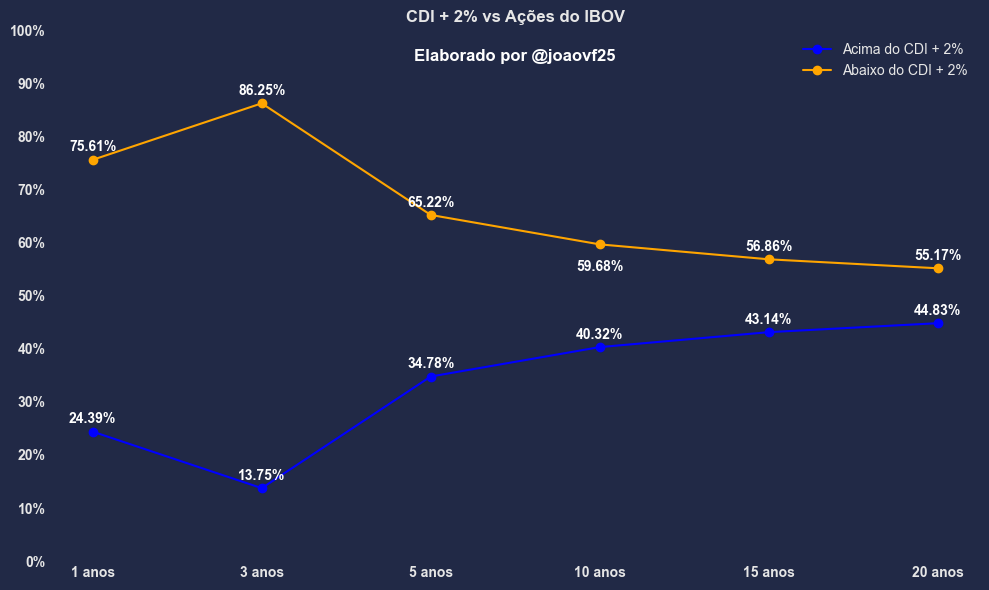

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
import time

# Lista de tickers e suas datas de início específicas
tickers_datas_inicio = {
    'LREN3.SA': '2005-07-01',
    'TRPL4.SA': '2006-05-09',
    'UGPA3.SA': '2007-05-07',
    'CMIG4.SA': '2006-05-09'
}

# Lista de outros tickers sem datas de início específicas
tickers = [
    'RRRP3.SA', 'ALOS3.SA', 'ALPA4.SA', 'ABEV3.SA', 'ARZZ3.SA', 'ASAI3.SA', 'AZUL4.SA', 
    'B3SA3.SA', 'BBSE3.SA', 'BBDC3.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 
    'BRFS3.SA', 'BPAC11.SA', 'CRFB3.SA', 'CCRO3.SA', 'CIEL3.SA', 'COGN3.SA', 
    'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CMIN3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 
    'ELET3.SA', 'EMBR3.SA', 'ENGI11.SA', 'ENEV3.SA', 'EGIE3.SA', 'EQTL3.SA', 
    'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'NTCO3.SA', 'SOMA3.SA', 'HAPV3.SA', 
    'HYPE3.SA', 'IGTI11.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 
    'RENT3.SA', 'LREN3.SA', 'LWSA3.SA', 'MGLU3.SA', 'MRFG3.SA', 'BEEF3.SA', 'MRVE3.SA', 
    'MULT3.SA', 'PCAR3.SA', 'PETR4.SA', 'RECV3.SA', 'PRIO3.SA', 'PETZ3.SA', 
    'RADL3.SA', 'RAIZ4.SA', 'RDOR3.SA', 'RAIL3.SA', 'SBSP3.SA', 'SANB11.SA', 'SMTO3.SA', 
    'CSNA3.SA', 'SLCE3.SA', 'SUZB3.SA', 'TAEE11.SA', 'VIVT3.SA', 'TIMS3.SA', 'TOTS3.SA', 
    'TRPL4.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VAMO3.SA', 'VBBR3.SA', 'VIVA3.SA', 
    'WEGE3.SA', 'YDUQ3.SA'
]

# Função para consultar dados do Banco Central com tentativas repetidas
def consulta_bc(codigo_bcb, data_inicio, data_fim):
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json&dataInicial={data_inicio.strftime("%d/%m/%Y")}&dataFinal={data_fim.strftime("%d/%m/%Y")}'
    while True:
        try:
            df_bcb = pd.read_json(url)
            df_bcb['data'] = pd.to_datetime(df_bcb['data'], dayfirst=True)
            df_bcb.set_index('data', inplace=True)
            return df_bcb
        except Exception as e:
            print(f"Erro ao consultar API do Banco Central: {e}")
            print("Tentando novamente em 1 segundo...")
            time.sleep(1)

# Função para calcular o retorno percentual
def calcular_retorno(data):
    retorno_pct = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    return retorno_pct

# Função para calcular o rendimento acumulado do CDI + 2% ao ano
def calcular_cdi_rendimento(cdi):
    cdi['valor'] = cdi['valor'] / 100
    cdi['acumulado'] = (1 + cdi['valor']).cumprod() - 1
    cdi_mais_2pct = (1 + cdi['acumulado']) * (1 + 0.02) ** (cdi.index.year - cdi.index.year[0]) - 1
    cdi_rendimento = cdi_mais_2pct.iloc[-1] * 100
    return cdi_rendimento

# Função para obter dados de um ticker com data de início específica
def obter_dados_ticker(ticker, data_inicio, data_fim):
    data = yf.download(ticker, start=data_inicio, end=data_fim)['Adj Close']
    data = data[(data != 0)]  # Remover linhas com valores 0
    return data

# Períodos em anos
periodos_anos = [1, 3, 5, 10, 15, 20]
resultados_acima = {}
resultados_abaixo = {}

for anos in periodos_anos:
    data_fim = datetime.today()
    data_inicio_padrao = data_fim - timedelta(days=365 * anos)
    
    # Inicializar DataFrame para armazenar todos os dados
    dados_acoes = pd.DataFrame()
    
    # Puxar dados de cada ticker individualmente
    for ticker, data_inicio_str in tickers_datas_inicio.items():
        data_inicio = datetime.strptime(data_inicio_str, '%Y-%m-%d')
        if data_inicio < data_inicio_padrao:
            data_inicio = data_inicio_padrao
        dados_ticker = obter_dados_ticker(ticker, data_inicio, data_fim)
        dados_acoes[ticker] = dados_ticker
    
    # Puxar dados de outros tickers
    for ticker in tickers:
        if ticker not in tickers_datas_inicio:
            dados_ticker = obter_dados_ticker(ticker, data_inicio_padrao, data_fim)
            dados_acoes[ticker] = dados_ticker

    # Verificar se há valores anômalos no início ou no fim dos dados
    dados_acoes = dados_acoes[(dados_acoes != 0).all(1)]  # Remover linhas com valores 0

    # Remover ativos que não possuem dados para todo o período
    dados_acoes = dados_acoes.dropna(axis=1, how='any')

    # Calcular o retorno percentual das ações
    retorno_pct = calcular_retorno(dados_acoes)
    df_retorno_pct = pd.DataFrame(retorno_pct, columns=['Retorno Percentual'])
    
    # Calcular o rendimento acumulado do CDI + 2%
    cdi = consulta_bc(12, data_inicio_padrao, data_fim)
    cdi_rendimento = calcular_cdi_rendimento(cdi)
    
    # Comparar os retornos das ações com o CDI + 2%
    acoes_acima_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] > cdi_rendimento]
    acoes_abaixo_cdi = df_retorno_pct[df_retorno_pct['Retorno Percentual'] <= cdi_rendimento]
    
    # Calcular a porcentagem de ações acima e abaixo do CDI + 2%
    porcentagem_acoes_acima_cdi = (len(acoes_acima_cdi) / len(df_retorno_pct)) * 100
    porcentagem_acoes_abaixo_cdi = (len(acoes_abaixo_cdi) / len(df_retorno_pct)) * 100
    
    resultados_acima[anos] = porcentagem_acoes_acima_cdi
    resultados_abaixo[anos] = porcentagem_acoes_abaixo_cdi

# Plotar os resultados
anos = list(resultados_acima.keys())
valores_acima = list(resultados_acima.values())
valores_abaixo = list(resultados_abaixo.values())

fig, ax1 = plt.subplots(figsize=(10, 6))

# Ajustar os índices para espaçamento uniforme
indices = range(len(anos))

ax1.plot(indices, valores_acima, marker='o', linestyle='-', color='b', label='Acima do CDI + 2%')
ax1.plot(indices, valores_abaixo, marker='o', linestyle='-', color='orange', label='Abaixo do CDI + 2%')
ax1.set_title('CDI + 2% vs Ações do IBOV', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()

# Ajustar os limites do eixo x e definir os ticks para garantir espaçamento uniforme
ax1.set_xticks(indices)
ax1.set_xticklabels([f'{ano} anos' for ano in anos], fontweight='bold')

# Adicionar mais divisões no eixo Y e formatar como porcentagem
ax1.set_yticks(range(0, 101, 10))
ax1.yaxis.set_major_formatter(PercentFormatter())
plt.setp(ax1.get_yticklabels(), fontweight='bold')

# Adicionar porcentagens acima dos pontos
for i, v in enumerate(valores_acima):
    ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar porcentagens abaixo dos pontos
for i, v in enumerate(valores_abaixo):
    if anos[i] == 10:
        ax1.text(i, v - 3, f"{v:.2f}%", ha='center', va='top', color='white', fontweight='bold')
    else:
        ax1.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', color='white', fontweight='bold')

# Adicionar texto "Elaborado por @joaovf25" no gráfico
plt.text(0.5, 0.95, "Elaborado por @joaovf25", fontsize=12, color='white', fontweight='bold', ha='center', va='center', transform=ax1.transAxes)

plt.grid(False)
plt.tight_layout()
plt.show()
